In [231]:
!nvidia-smi

Sat Apr 10 22:27:42 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    34W /  70W |   2272MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
%cd /content

/content


In [3]:
%pip install -q tensorflow-addons[tensorflow]
%pip install -q wandb

     |████████████████████████████████| 706kB 8.8MB/s 
     |████████████████████████████████| 2.1MB 7.7MB/s 
     |████████████████████████████████| 133kB 53.3MB/s 
     |████████████████████████████████| 163kB 37.0MB/s 
     |████████████████████████████████| 102kB 10.1MB/s 
     |████████████████████████████████| 71kB 9.8MB/s 


In [4]:
!git clone https://github.com/ShivamShrirao/tiny-imagenet-test

Cloning into 'tiny-imagenet-test'...
remote: Enumerating objects: 86, done.
remote: Counting objects: 100% (86/86), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 86 (delta 50), reused 61 (delta 25), pack-reused 0
Unpacking objects: 100% (86/86), done.


In [5]:
%cd tiny-imagenet-test

/content/tiny-imagenet-test


In [ ]:
!git pull

In [7]:
%load_ext autoreload
%autoreload 2

In [8]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image
import glob
import os
import csv
from tqdm.notebook import tqdm
from time import time
import random
%matplotlib inline

In [14]:
import tensorflow_addons as tfa
import tensorflow_datasets as tfds

In [10]:
import wandb
from wandb.keras import WandbCallback

In [11]:
tf.keras.backend.set_image_data_format('channels_first')

In [12]:
from tensorflow.keras.mixed_precision import experimental as mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5
Instructions for updating:
Use tf.keras.mixed_precision.LossScaleOptimizer instead. LossScaleOptimizer now has all the functionality of DynamicLossScale


In [16]:
from resnet import *

In [ ]:
# def ResAttnnet50(inputs=None,
#              input_shape=(3,224,224),
#              num_classes=1000,
#              dp_rate=0,
#              activation=tf.nn.relu):

#     return Resnet(AttnBottleneck, num_repeats=[3,4,6,3], inputs=inputs, input_shape=input_shape, num_classes=num_classes,
#                   dp_rate=dp_rate, activation=activation, self_attn=[False,False,True,True], nheads=8, pos_emb=True, frac_dk=1, frac_dv=1)

In [55]:
model = Resnet50(input_shape=(3,224,224), num_classes=10).get_model()

In [56]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 3, 224, 224) 0                                            
__________________________________________________________________________________________________
conv2d_106 (Conv2D)             (None, 64, 112, 112) 9472        input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_8 (MaxPooling2D)  (None, 64, 56, 56)   0           conv2d_106[0][0]                 
__________________________________________________________________________________________________
batch_normalization_98 (BatchNo (None, 64, 56, 56)   256         max_pooling2d_8[0][0]            
____________________________________________________________________________________________

In [232]:
train_inpds = tfds.load("imagenette/320px-v2", split='train', shuffle_files=True)
val_inpds = tfds.load("imagenette/320px-v2", split='validation')

In [233]:
BATCH_SIZE = 128
img_height, img_width = 224, 224

In [234]:
AUTOTUNE = tf.data.AUTOTUNE

In [235]:
rng = tf.random.Generator.from_seed(123, alg='philox')
def preproc_img(inp):
    img, lbl = inp['image'], inp['label']
    seed = rng.make_seeds(2)[0]
    img = tf.image.resize(img, (320, 320))
    img = img/255.0
    return img, lbl

def augment(img, lbl):         # over batches
    seed = rng.make_seeds(2)[0]
    img = tf.image.stateless_random_saturation(img, 0.3, 3, seed)
    img = tf.image.stateless_random_hue(img, 0.08, seed)
    img = tf.image.stateless_random_contrast(img, 0.4, 1, seed)
    img = tf.image.stateless_random_brightness(img, 0.3, seed)
    img = tf.clip_by_value(img, 0, 1)
    return img, lbl

augmentation_layers = tf.keras.Sequential([                       # over batches
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomHeight(0.3),
    layers.experimental.preprocessing.RandomWidth(0.3),
    layers.experimental.preprocessing.RandomTranslation(0.2,0.2),
    layers.experimental.preprocessing.RandomRotation(0.12),     # 0.12 * 2pi = 43.2 deg
    layers.experimental.preprocessing.Resizing(img_height, img_width)
])
def augmentation_layers_wrapper(x, y):
    with tf.device('/device:GPU:0'):
        x, y = augmentation_layers(x, training=True), y
        return x, y

def channel_first(img, lbl):    # over batches
    with tf.device('/device:GPU:0'):
        img = tf.image.resize(img, (img_height, img_width))
        img = tf.transpose(img, perm=[0,3,1,2])
    return img, lbl

In [236]:
train_ds = (
    train_inpds
    .map(preproc_img, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .map(augment, num_parallel_calls=AUTOTUNE)
    .map(augmentation_layers_wrapper, num_parallel_calls=AUTOTUNE)
    .map(channel_first, num_parallel_calls=AUTOTUNE)
    .prefetch(AUTOTUNE)
    )

In [237]:
val_ds = (
    val_inpds
    .map(preproc_img, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .map(channel_first, num_parallel_calls=AUTOTUNE)
    .prefetch(AUTOTUNE)
    )

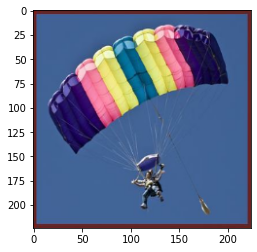

In [240]:
a, b = next(iter(val_ds))
plt.imshow(a[0].numpy().transpose(1,2,0))

In [242]:
class AttributeDict(dict):
    __slots__ = () 
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

In [243]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [244]:
config_defaults = {
    'activation'            : 'relu',
    'dp_rate'               : 0,
    'batch_size'            : BATCH_SIZE,
    'optimizer'             : 'adamw',
    'lr'                    : 8e-4,
    'weight_decay'          : 2e-6,
    'loss_function'         : 'cce',
}

In [245]:
CONFIG = AttributeDict(config_defaults)

In [246]:
if CONFIG.optimizer == 'adamw':
    opt = tfa.optimizers.AdamW(learning_rate=CONFIG.lr, weight_decay=CONFIG.weight_decay)
opt = tf.keras.mixed_precision.LossScaleOptimizer(opt)

In [247]:
if CONFIG.loss_function == 'cce':
    loss_function = tf.keras.losses.SparseCategoricalCrossentropy()

In [248]:
model.compile(optimizer=opt, loss=loss_function, metrics=['accuracy'])

In [ ]:
history = model.fit(train_ds,
                    epochs=100,
                    validation_data=val_ds,
                    workers=4,
                    use_multiprocessing=True,
                    callbacks=[])

Epoch 1/100
74/74 [==============================] - 132s 1s/step - loss: 2.1460 - accuracy: 0.2798 - val_loss: 4.7186 - val_accuracy: 0.0994
Epoch 2/100
74/74 [==============================] - 83s 1s/step - loss: 1.7110 - accuracy: 0.4164 - val_loss: 4.4832 - val_accuracy: 0.0994
Epoch 3/100
74/74 [==============================] - 82s 1s/step - loss: 1.5240 - accuracy: 0.4819 - val_loss: 2.2546 - val_accuracy: 0.2622
Epoch 4/100
74/74 [==============================] - 82s 1s/step - loss: 1.3850 - accuracy: 0.5399 - val_loss: 3.9303 - val_accuracy: 0.2948
Epoch 5/100
74/74 [==============================] - ETA: 0s - loss: 1.2716 - accuracy: 0.5830

In [ ]:
# decisive_depth
# x = block(args)(x)
# gp = globalpool(x)
# gamma = dense(1)(gp) # sigmoid or simply relu
# next_block = block(args)
# def call(args):         # or process in batch and mask with 0
#     x, next_block, gamma = args
#     if gamma > 0.5:
#         x = next_block(x)
#     else:
#         x = pool(x) (if stride>1 else x) or pointwise(x)
# x = tf.map_fn(call, (x, next_block, gamma))
# x = block(args)(x)